## Wine dataset

* dataset: https://odds.cs.stonybrook.edu/wine-dataset/

* Dataset Information:

    > The original Wine dataset from UCI machine learning repository is a multiclass classification dataset having 13 attributes and 3 classes. These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines. Class 2 and 3 are used as inliers and class 1 is downsampled to 10 instances to be used as ouliers.

**1. Dla każdego zbioru** badamy skuteczność wykrywania anomalii za pomocą 3 metod - np. podanych w tej instrukcji, można też użyć inne metody (np. kNN). Staramy się dostroić parametry detektora anomalii tak żeby uzyskać wysoką skuteczność metody. 

**2. Opracowujemy raport z badań** - powinien zawierać miary skuteczności każdej badanej metody (ROC, AUC, FPR, TPR) oraz wpływ parametrów, które poddawaliśmy strojeniu. 


In [66]:
# import libraries

import time

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import scipy


# IRW
from openset.IRW_score import IRWdepth
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import RocCurveDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor

In [67]:
wine_dataset_path = Path('../data/arrhythmia.mat')

In [68]:
wine = scipy.io.loadmat(wine_dataset_path)

In [59]:
X = wine['X']
y = wine['y']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [70]:
X.shape, y.shape

((452, 274), (452, 1))

### LOF

In [75]:
model = LocalOutlierFactor(novelty=False, n_neighbors=35, contamination='auto')
y_pred = model.fit_predict(X_train)

In [76]:
y_pred[y_pred==1] = 0    # inliers
y_pred[y_pred==-1] = 1   # outliers

In [77]:
print(np.array(np.unique(y_train, return_counts=True)))

print(np.array(np.unique(y_pred, return_counts=True)))

[[  0   1]
 [307  54]]
[[  0   1]
 [329  32]]


In [79]:
confusion_matrix(y_train, y_pred)

array([[293,  14],
       [ 36,  18]])

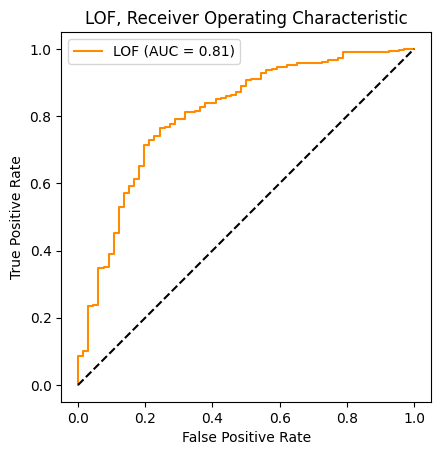

In [80]:
### plot ROC curve
model.fit(X)
y_pred = model.negative_outlier_factor_
RocCurveDisplay.from_predictions(
    y,
    y_pred,
    name="LOF",
    color="darkorange",
    pos_label=0
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LOF, Receiver Operating Characteristic")
plt.legend()
plt.show()

### IRW

fitted IRWdepth model with 100 projections in 452 dimensions
--- 0.9896972179412842 seconds ---
0.2513336847008065
0.24465647184673733


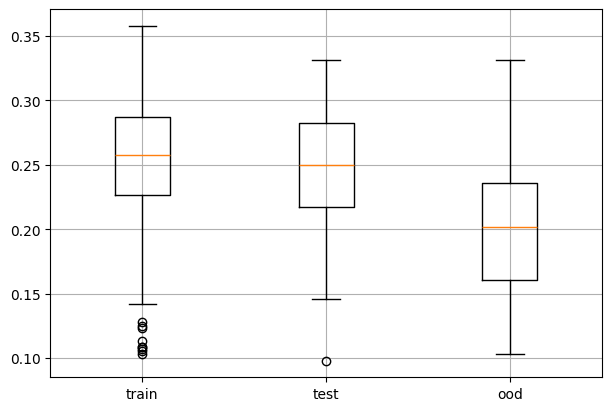

In [87]:
model = IRWdepth()
nproj = 100
model.fit(X, nproj)

start_time = time.time()
train_scores = [model.score(row) for row in X_train]
test_scores = [model.score(row) for row in X_test]
ood_scores = [model.score(row) for row in X_train[y_train.T[0] == 1]]
print("--- %s seconds ---" % (time.time() - start_time))

if 1:
    print(np.mean(train_scores))
    print(np.mean(test_scores))


# boxplot
fig, ax1 = plt.subplots(figsize=(6, 4), constrained_layout=True)

labels = ['train', 'test', 'ood']
#ax1.set_ylim([40, 65])
ax1.boxplot([train_scores, test_scores, ood_scores], labels=labels)
ax1.grid()

plt.show()

### Mahalanobis distance

/home/jakub/miniconda3/envs/openset/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


-6262.353901113839
-15044.034245474417
-20454.117884950065


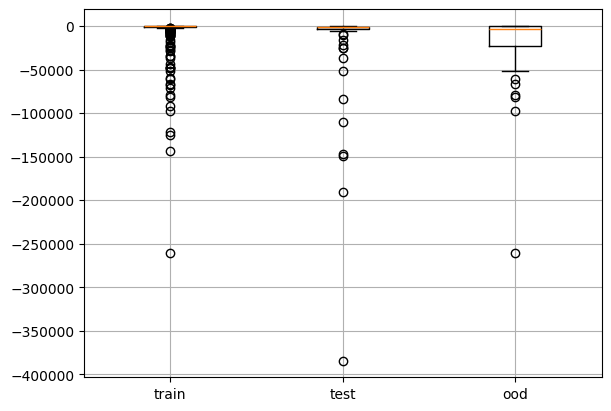

In [88]:

model = EllipticEnvelope(contamination=0.01, random_state=42)

model.fit(X_train)

train_scores = model.score_samples(X_train)
test_scores = model.score_samples(X_test)
ood_scores = model.score_samples(X_train[y_train.T[0] == 1])


if 1:
    print(np.mean(train_scores))
    print(np.mean(test_scores))
    print(np.mean(ood_scores))


# boxplot
fig, ax1 = plt.subplots(figsize=(6, 4), constrained_layout=True)

labels = ['train', 'test', 'ood']
#ax1.set_ylim([40, 65])
ax1.boxplot([train_scores, test_scores, ood_scores], labels=labels)
ax1.grid()

plt.show()